In [ ]:
import timm
from pprint import pprint

# 모델 목록 확인
model_names = timm.list_models(pretrained=True)
pprint(model_names)
print(len(model_names))

['aimv2_1b_patch14_224.apple_pt',
 'aimv2_1b_patch14_336.apple_pt',
 'aimv2_1b_patch14_448.apple_pt',
 'aimv2_3b_patch14_224.apple_pt',
 'aimv2_3b_patch14_336.apple_pt',
 'aimv2_3b_patch14_448.apple_pt',
 'aimv2_huge_patch14_224.apple_pt',
 'aimv2_huge_patch14_336.apple_pt',
 'aimv2_huge_patch14_448.apple_pt',
 'aimv2_large_patch14_224.apple_pt',
 'aimv2_large_patch14_224.apple_pt_dist',
 'aimv2_large_patch14_336.apple_pt',
 'aimv2_large_patch14_336.apple_pt_dist',
 'aimv2_large_patch14_448.apple_pt',
 'bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patc

In [24]:
# timm에서 미리 구현 및 pretrained 모델 선택
model = timm.create_model(model_name="vit_small_patch16_224", pretrained=True)

In [3]:
import torch
from torchvision.transforms import v2

transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((224, 224), antialias=True),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

In [4]:
!wget https://upload.wikimedia.org/wikipedia/commons/6/62/Big_and_little_dog.jpg -O sample.png


--2025-05-04 19:58:49--  https://upload.wikimedia.org/wikipedia/commons/6/62/Big_and_little_dog.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93379 (91K) [image/jpeg]
Saving to: ‘sample.png’

sample.png          100%[===================>]  91.19K   604KB/s    in 0.2s    

2025-05-04 19:58:49 (604 KB/s) - ‘sample.png’ saved [93379/93379]



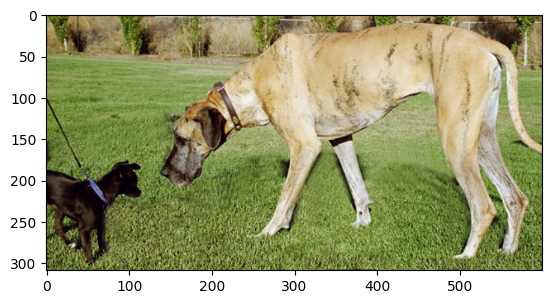

In [5]:
import matplotlib.pyplot as plt
from PIL import Image


sample_img = Image.open("sample.png")
plt.imshow(sample_img)

In [6]:
sample_input = transforms(sample_img).unsqueeze(0)
sample_output = model(sample_input)
sample_output.shape

torch.Size([1, 1000])

In [ ]:
# 위의 이미지를 vit로 예측 결과 보기

!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))
imagenet_labels[int(torch.argmax(sample_output))]

--2025-05-04 19:58:50--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 34.128.9.187, 34.64.4.91, 34.128.9.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|34.128.9.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0.06s   

2025-05-04 19:58:51 (385 KB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



'Great_Dane\n'

In [8]:
patches = model.patch_embed(sample_input)
print(sample_input.shape)
print(patches.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 196, 384])


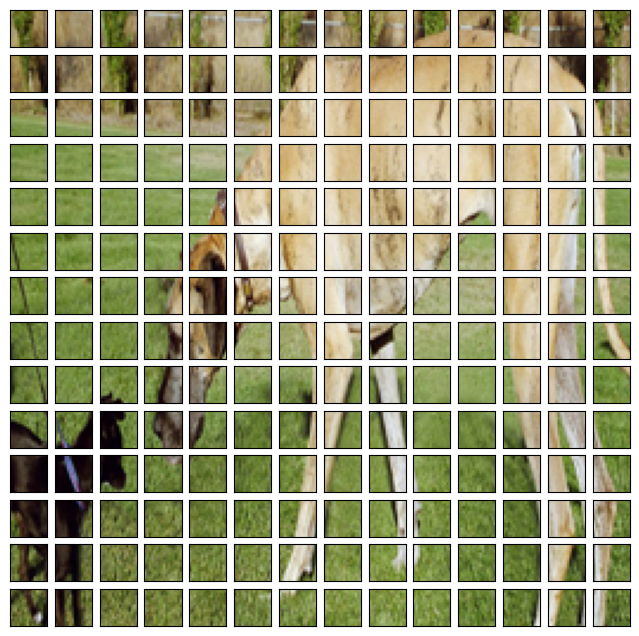

In [ ]:
import numpy as np

# 이미지의 패치 시각화

fig = plt.figure(figsize=(8, 8))
img = np.asarray(sample_img.resize((224, 244)))
for i in range(0, 14 * 14):
    x = i % 14
    y = i // 14
    patch = img[y * 16 : (y + 1) * 16, x * 16 : (x + 1) * 16]
    ax = fig.add_subplot(14, 14, i + 1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

In [ ]:
# 196개 토큰 + class 토큰
pos_embed = model.pos_embed
pos_embed.shape

torch.Size([1, 197, 384])

In [11]:
attention = model.blocks[0].attn
attention

Attention(
  (qkv): Linear(in_features=384, out_features=1152, bias=True)
  (q_norm): Identity()
  (k_norm): Identity()
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=384, out_features=384, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)

In [12]:
transformer_input = torch.cat((model.cls_token, patches), dim=1) + pos_embed
transformer_input.shape

torch.Size([1, 197, 384])

In [13]:
transformer_input_expanded = attention.qkv(transformer_input)[0]
print(transformer_input_expanded.shape)

torch.Size([197, 1152])


In [14]:
qkv = transformer_input_expanded.reshape(197, 3, 12, 32)  # (N=197, (qkv), H=12, D/H=32)
qkv.shape

torch.Size([197, 3, 12, 32])

In [15]:
q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=32)
k = qkv[:, 1].permute(1, 0, 2)  # (H=12, N=197, D/H=32)
kT = k.permute(0, 2, 1)  # (H=12, D/H=32, N=197)

In [16]:
attention_matrix = q @ kT
attention_matrix.shape

torch.Size([12, 197, 197])

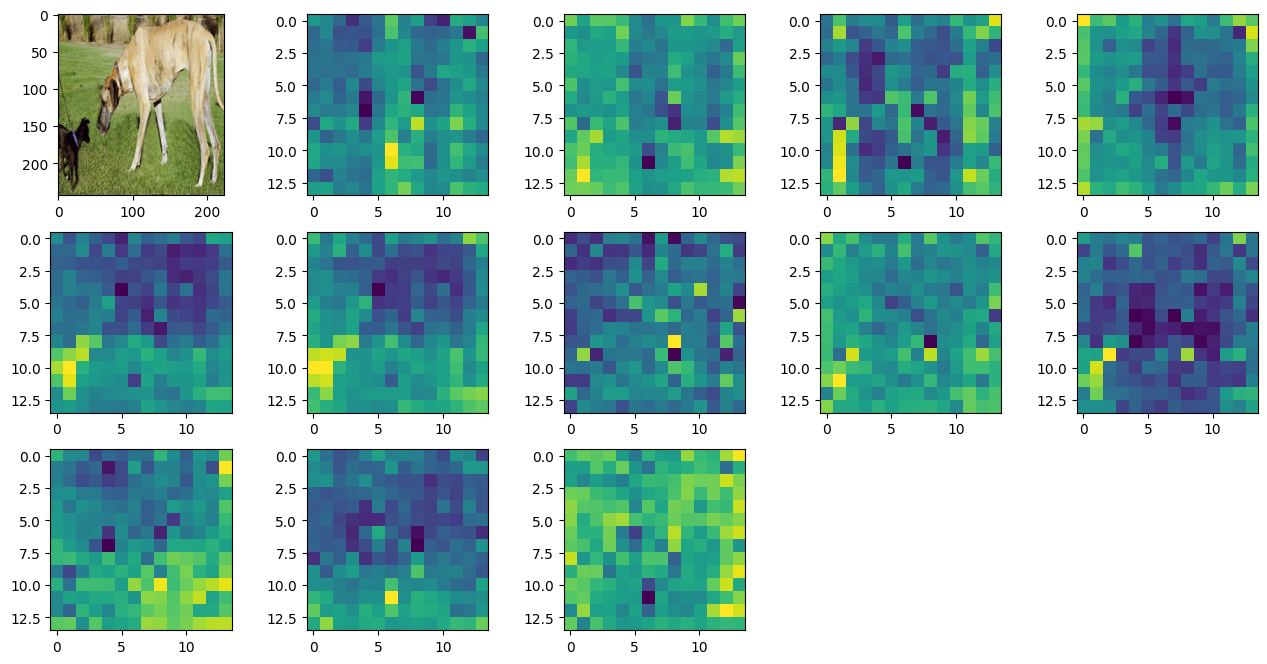

In [ ]:
# 각 head의 attn matrix 시각화 - 모델이 어떤것에 집중하고 있는가

fig = plt.figure(figsize=(16, 8))
img = np.asarray(img)
ax = fig.add_subplot(3, 5, 1)
ax.imshow(img)
for head in range(len(attention_matrix)):
    # 첫 클래스 토크 제외
    attn_heatmap = attention_matrix[head, 1:, 0].reshape((14, 14)).detach().numpy()
    ax = fig.add_subplot(3, 5, head + 2)
    ax.imshow(attn_heatmap)

In [ ]:
from torchvision.datasets import CIFAR10

# 데이터 다운로드
trn_dataset = CIFAR10(".", train=True, download=True, transform=transforms)
test_dataset = CIFAR10(".", train=False, download=True, transform=transforms)

100%|██████████| 170M/170M [00:15<00:00, 10.7MB/s] 


In [ ]:
# 데이터 로더 설정
batch_size = 128
trn_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
import torch.nn as nn
import torch.optim as optim

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
from tqdm import tqdm


def train(model, criterion, optimizer, trn_loader, test_loader, num_epochs):
    for epoch in range(num_epochs):

        model.train()
        trn_loss = 0.0
        trn_corrects = 0
        for inputs, labels in tqdm(trn_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            trn_loss += loss.item() * inputs.size(0)
            trn_corrects += torch.sum(preds == labels.data)

        trn_epoch_loss = trn_loss / len(trn_loader.dataset)
        trn_epoch_acc = trn_corrects.double() / len(trn_loader.dataset)
        print(f"[Train] Loss: {trn_epoch_loss:.4f} Acc: {trn_epoch_acc:.4f}:")

        with torch.no_grad():
            model.eval()
            test_loss = 0.0
            test_corrects = 0
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                test_corrects += torch.sum(preds == labels.data)

            test_epoch_loss = test_loss / len(test_loader.dataset)
            test_epoch_acc = test_corrects.double() / len(test_loader.dataset)
            print(f"[Test] Loss: {test_epoch_loss:.4f} Acc: {test_epoch_acc:.4f}:")

In [23]:
train(model, criterion, optimizer, trn_loader, test_loader, num_epochs=10)

100%|██████████| 391/391 [01:54<00:00,  3.43it/s]


[Train] Loss: 1.7846 Acc: 0.3547:


100%|██████████| 79/79 [00:08<00:00,  8.93it/s]


[Test] Loss: 1.2634 Acc: 0.5279:


100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


[Train] Loss: 1.0680 Acc: 0.6151:


100%|██████████| 79/79 [00:08<00:00,  9.02it/s]


[Test] Loss: 0.9737 Acc: 0.6384:


100%|██████████| 391/391 [01:52<00:00,  3.47it/s]


[Train] Loss: 0.8189 Acc: 0.7089:


100%|██████████| 79/79 [00:08<00:00,  9.06it/s]


[Test] Loss: 0.7760 Acc: 0.7267:


100%|██████████| 391/391 [01:53<00:00,  3.45it/s]


[Train] Loss: 0.6817 Acc: 0.7601:


100%|██████████| 79/79 [00:07<00:00, 10.21it/s]


[Test] Loss: 0.6915 Acc: 0.7540:


100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


[Train] Loss: 0.5664 Acc: 0.7999:


100%|██████████| 79/79 [00:07<00:00, 10.17it/s]


[Test] Loss: 0.6574 Acc: 0.7748:


100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


[Train] Loss: 0.4886 Acc: 0.8264:


100%|██████████| 79/79 [00:08<00:00,  9.01it/s]


[Test] Loss: 0.6055 Acc: 0.7907:


100%|██████████| 391/391 [01:52<00:00,  3.46it/s]


[Train] Loss: 0.4195 Acc: 0.8527:


100%|██████████| 79/79 [00:08<00:00,  8.80it/s]


[Test] Loss: 0.6194 Acc: 0.7881:


100%|██████████| 391/391 [01:55<00:00,  3.39it/s]


[Train] Loss: 0.3683 Acc: 0.8689:


100%|██████████| 79/79 [00:09<00:00,  8.56it/s]


[Test] Loss: 0.5716 Acc: 0.8061:


100%|██████████| 391/391 [01:58<00:00,  3.30it/s]


[Train] Loss: 0.3215 Acc: 0.8862:


100%|██████████| 79/79 [00:10<00:00,  7.51it/s]


[Test] Loss: 0.5567 Acc: 0.8174:


100%|██████████| 391/391 [02:16<00:00,  2.87it/s]


[Train] Loss: 0.2794 Acc: 0.9012:


100%|██████████| 79/79 [00:10<00:00,  7.25it/s]

[Test] Loss: 0.5783 Acc: 0.8168:
